In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Notebook to do time series analysis on crime in San Francisco from 2003 - 2017


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

## Import data and look at some trends with time

In [4]:
# Import and turn date and time into single timestamp and then use resampling for plotting
df = pd.read_csv('../../Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv', 
                  parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True)

# Show all columns of dataframe
pd.set_option('display.max_columns', None)

In [5]:
# Keep columns and sort by date/time
df = df[['Category', 'Descript', 'DayOfWeek', 'Datetime', 'X', 'Y', 'PdDistrict', 'Resolution']]

data = (
    df.dropna()
    .sort_values(by='Datetime')
)

# Set index to datetime object for resampling
data = data.set_index('Datetime')

In [6]:
data.head()

,Category,Descript,DayOfWeek,X,Y,PdDistrict,Resolution
Datetime,,,,,,,
2003-01-01 00:01:00,FORGERY/COUNTERFEITING,"FORGERY, FALSE ENTRIES IN RECORDS OR RETURNS",Wednesday,-122.403405,37.775421,SOUTHERN,NONE
2003-01-01 00:01:00,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Wednesday,-122.424037,37.762751,MISSION,NONE
2003-01-01 00:01:00,NON-CRIMINAL,"DEATH REPORT, CAUSE UNKNOWN",Wednesday,-122.415065,37.776435,SOUTHERN,NONE
2003-01-01 00:01:00,OTHER OFFENSES,FORTUNE TELLING,Wednesday,-122.392671,37.782399,SOUTHERN,"ARREST, BOOKED"
2003-01-01 00:01:00,OTHER OFFENSES,OBSCENE PHONE CALLS(S),Wednesday,-122.500300,37.757847,TARAVAL,NONE


Text(0, 0.5, 'Counts')

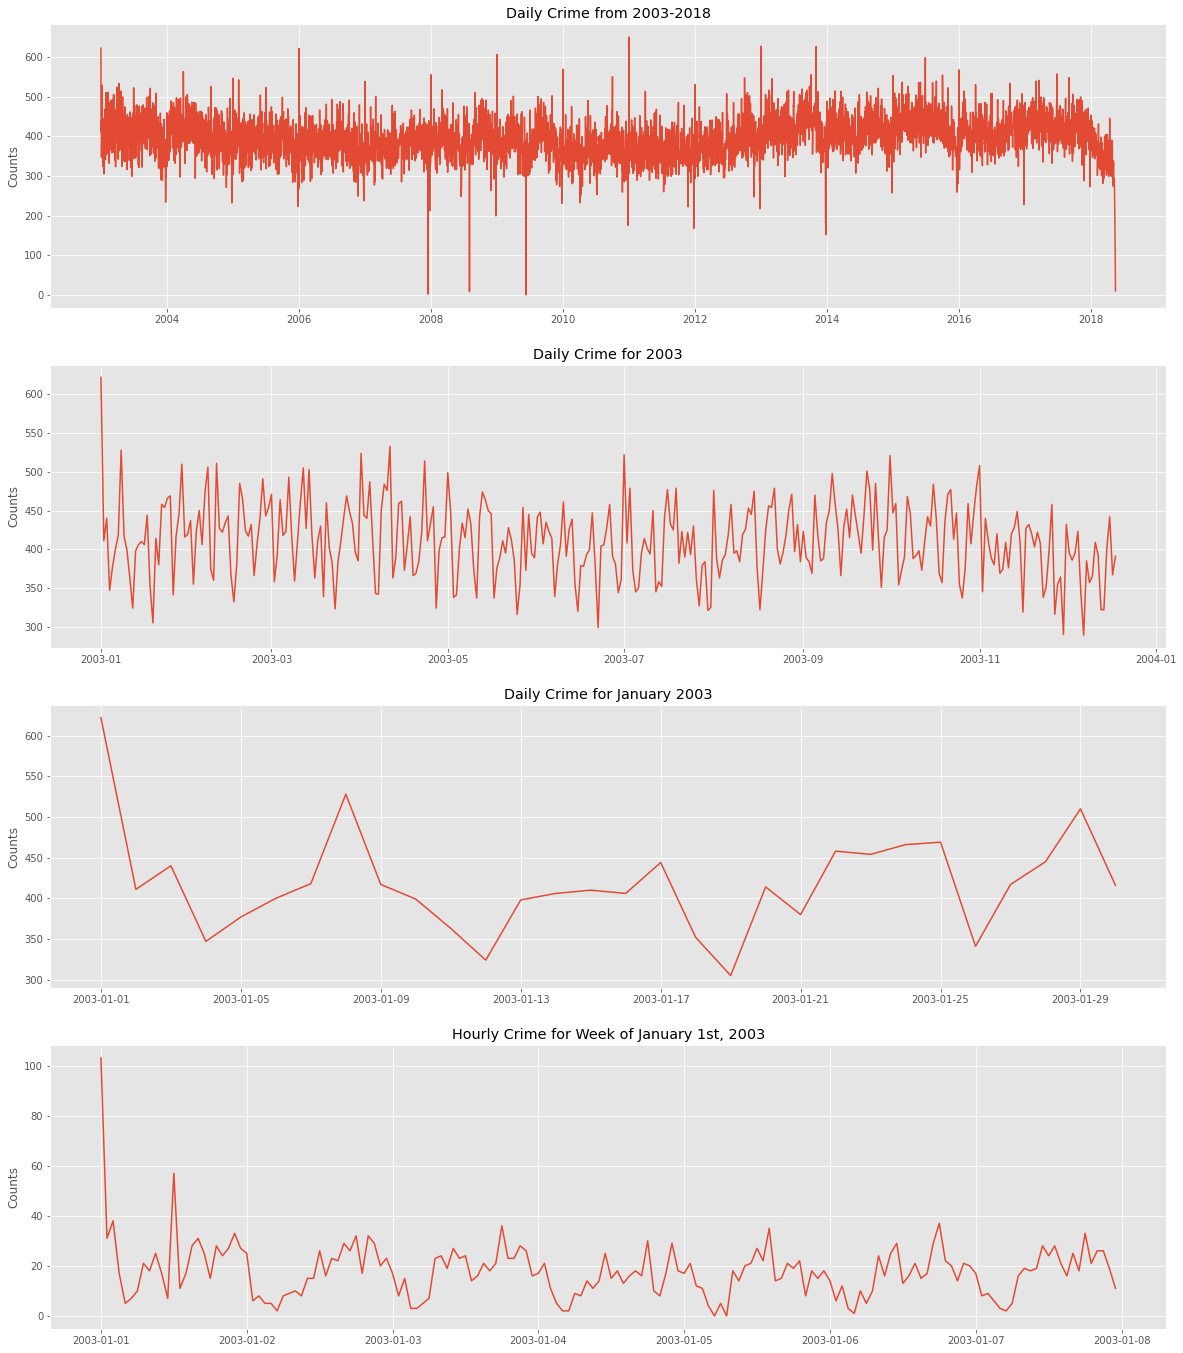

In [7]:
# Plot crimes using resampling
fig, axes = plt.subplots(4, 1, figsize=(20,24))
ax = axes[0]
ax.plot(data.resample('D').count()['Category'])
ax.set_title('Daily Crime from 2003-2018')
ax.set_ylabel('Counts')

ax = axes[1]
ax.plot(data.resample('D').count()['Category'].iloc[0:352])
ax.set_title('Daily Crime for 2003')
ax.set_ylabel('Counts')

ax = axes[2]
ax.plot(data.resample('D').count()['Category'].iloc[0:30])
ax.set_title('Daily Crime for January 2003')
ax.set_ylabel('Counts')

ax = axes[3]
ax.plot(data.resample('H').count()['Category'].iloc[0:168])
ax.set_title('Hourly Crime for Week of January 1st, 2003')
ax.set_ylabel('Counts')

#plt.savefig('../data/images/Crimetrends.png', bbox_inches='tight', dpi=350)

Text(0, 0.5, 'Counts')

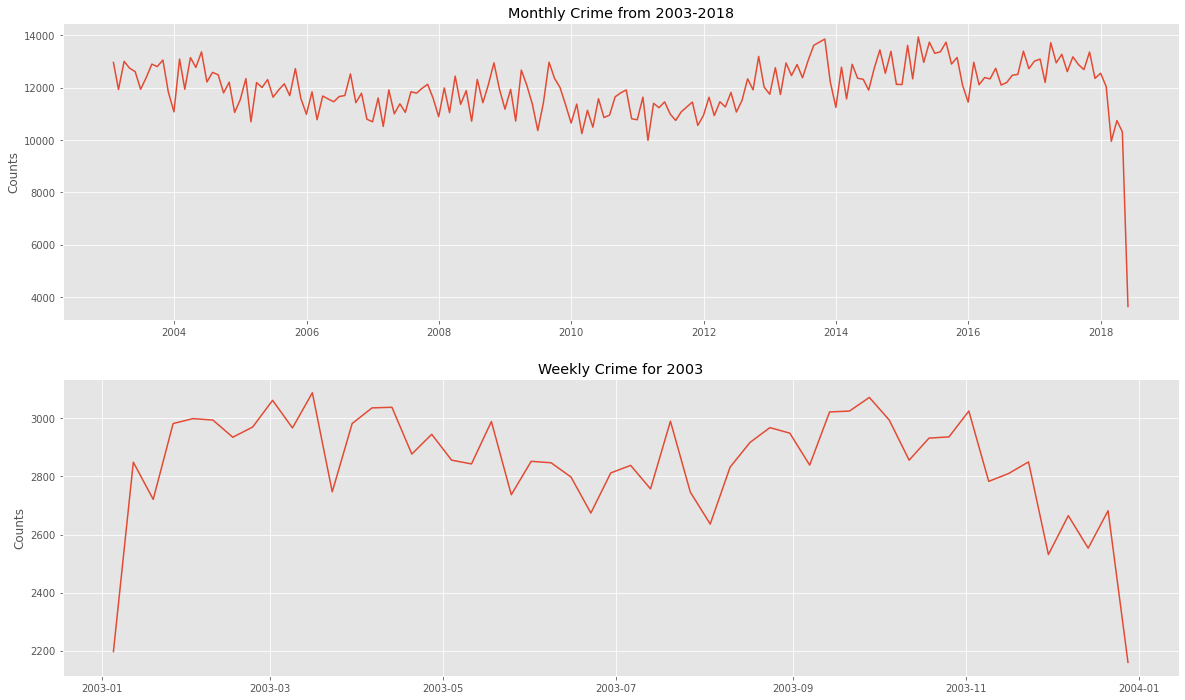

In [8]:
# Breakdown into different timescales
fig, axes = plt.subplots(2, 1, figsize=(20,12))
ax = axes[0]
ax.plot(data.resample('M').count()['Category'])
ax.set_title('Monthly Crime from 2003-2018')
ax.set_ylabel('Counts')

ax = axes[1]
ax.plot(data.resample('W').count()['Category'].iloc[0:52])
ax.set_title('Weekly Crime for 2003')
ax.set_ylabel('Counts')

#plt.savefig('../data/images/Crimetrends2.png', bbox_inches='tight', dpi=350)

In [9]:
# Remove data from 2018 from analysis
data = data.loc[:'2017-12-31']

### Trend Analysis

Looking at the data at various time scales shows that we may have a few different frequency components: hourly, weekly and seasonal.

Let's now explore the following:
- Decompose the data using trend-season-residual decomposition. 
- Check for stationarity
- Do some differencing
- Moving Average and autocorrelation
- ARIMA model (if stationarity proven)

In [10]:
# Start with imports
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [11]:
# For funsies, let's fit a linear trend line to the data
def fit_linear_trend(series):
    
    # Add in constant/intercept for OLS model
    X = (np.arange(len(series)) + 1).reshape(-1,1)
    X = sm.add_constant(X, prepend=False)
    
    # Fit line
    model = sm.OLS(series.values, X).fit()
    y_hat = model.predict(X)
    
    # Other things we likely don't need
    params = model.params
    
    return y_hat

def plot_series(ax, name, series):
    y_predict = fit_linear_trend(series)
    
    # Plot the data and fit line
    ax.plot(series.index.date, series)
    ax.plot(series.index.date, y_predict)
    ax.set_title(name)

In [12]:
# Redefine our data with monthly resampling
series = data.resample('M').count()['Category']
y_predict = fit_linear_trend(series)

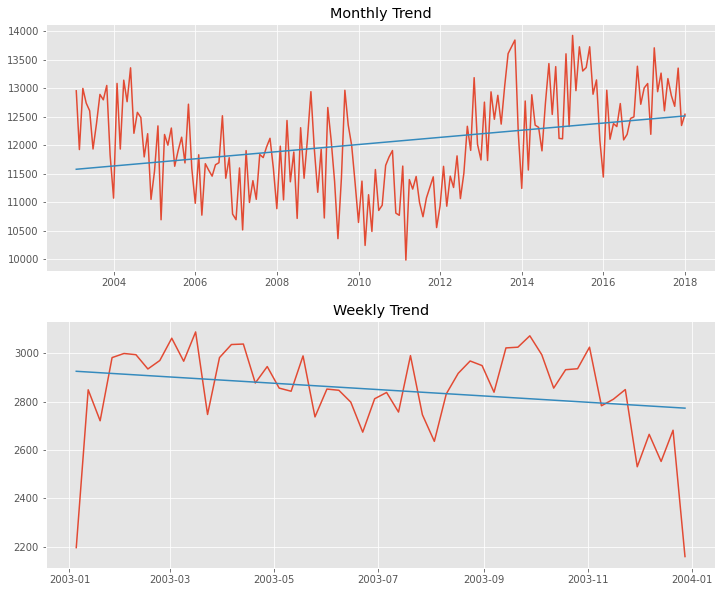

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12,10))
plot_series(axes[0], 'Monthly Trend', data.resample('M').count()['Category'])
plot_series(axes[1], 'Weekly Trend', data.resample('W').count()['Category'].iloc[:52])

### Trend-Seasonal-Decomposition

In [29]:
# Pick resampling and get decomp
series = data.resample('Y').count()['Category'].iloc[:365]
decomp = sm.tsa.seasonal_decompose(series)

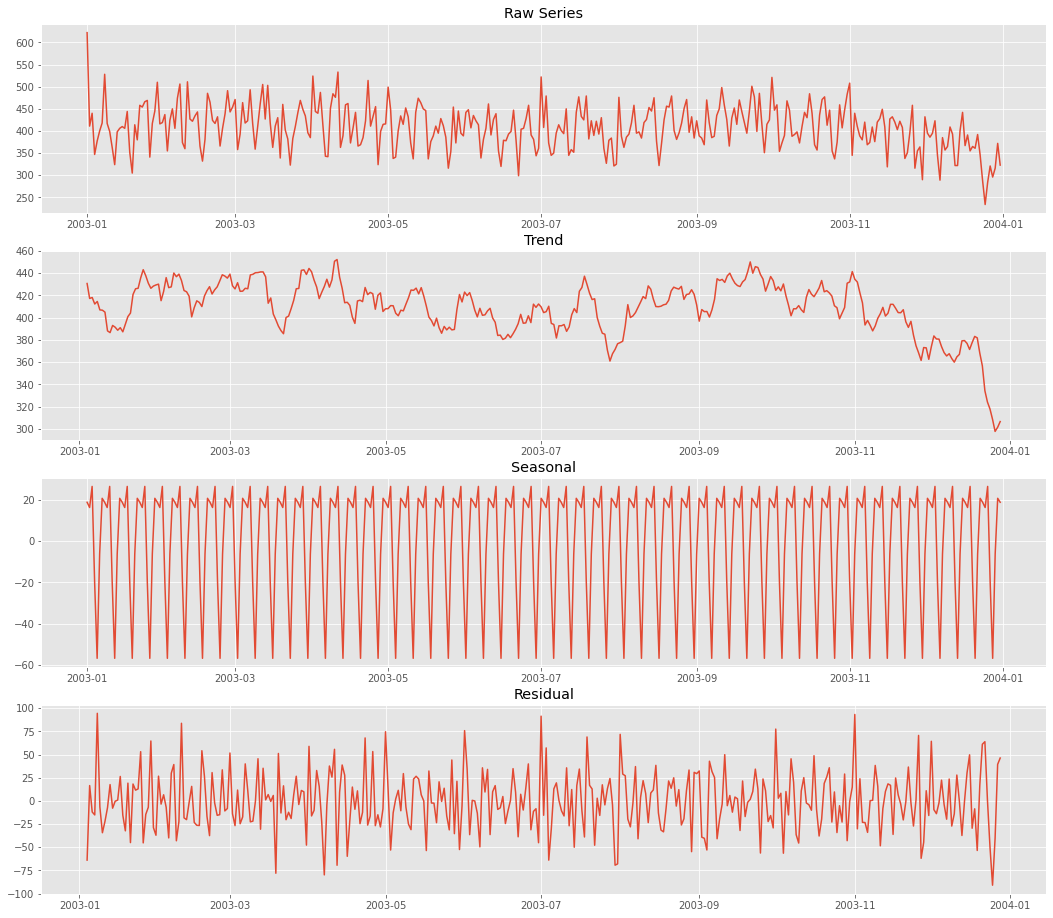

In [17]:
# Statsmodel decomp has 3 components. Let's plot them
fig, axes = plt.subplots(4,1, figsize=(18, 16))

names = ['Raw Series', 'Trend', 'Seasonal', 'Residual']
components = [series, decomp.trend, decomp.seasonal, decomp.resid]

for ax, name, comp in zip(axes, names, components):
    ax.plot(series.index, comp)
    ax.set_title(name)

plt.savefig('../data/images/tsadecomp_day2.png', bbox_inches='tight', dpi=250)

### Analysis so far

1. We see some pretty strong signals in the decomposition. 
2. There is clearly a trend within our data, which means it's not stationary and thus doesn't satisfy the requirements for ARIMA modeling. 
3. The residual component looks to be quite large (how do we quantify this?), which implies that there is a lot of crime that can't be explained by trend or seasonality. 
4. The sampling on the monthly vs weekly timescale can give us more information, specifically showing perdiodic components on both timescales. 
5. Resampling on a daily basis and then looking at the decomposition shows that there are more crimes reported in the evening (as we saw during EDA).

### Next Steps

1. Check stationarity with Dickey-Fuller Test
2. Look at and plot autocorrelations within the data
3. Make data stationary via differencing
4. Apply ARIMA model
5. Look into other forecasting methods, like LightGBM
6. Look into multivariate methods used for non-stationary data

In [32]:
# Make is easy to sample data at different intervals
def series_sample(series, string):
    return data.resample(string).count()['Category']

In [125]:
# Test stationarity using augmented Dickey-Fuller Test
# Taken from https://github.com/mkpetterson/Collisions_Data/blob/master/Collisions_TimeSeries.ipynb
# H0: Time series is NOT stationary. We want to reject the null. 
# The ADF test statistic is a negative number - the more negative it is, the stronger the rejection of the null hypothesis.
from statsmodels.tsa.stattools import adfuller
X = series
adf_result = adfuller(X)
adf_result
print(f'test statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(key, value)

test statistic: -2.4760229589449576
p-value: 0.12141771785633415
Critical Values:
1% -3.438938229437747
5% -2.8653304587462944
10% -2.568788425002056


The test statistic is greater than even the 10% confidence level, so we fail to reject the null and can't conclude that the series is stationary.

Onto correlations and differencing:
- Autocorrelations look at the correlation of data with itself
- Partial autocorrelation attempts to remove the linear relationship between serialized observations
- Differencing attempts to stabalize the variance by taking the difference between consecutive observations

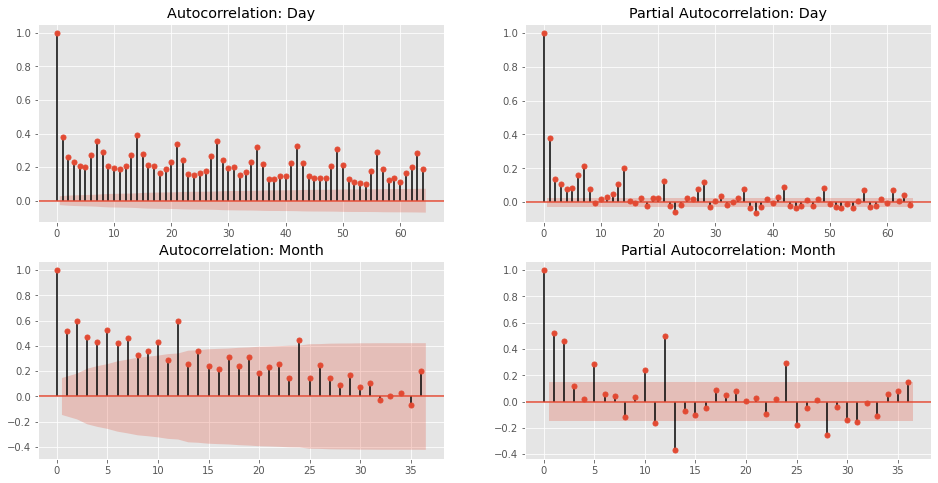

In [44]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(16,8))

_ = plot_acf(series_sample(data, 'D'), ax=axes[0,0], lags=64,
             title="Autocorrelation: Day")
_ = plot_pacf(series_sample(data, 'D'), ax=axes[0,1], lags=64,
              title="Partial Autocorrelation: Day")

_ = plot_acf(series_sample(data, 'M'), ax=axes[1,0], lags=36,
             title="Autocorrelation: Month")
_ = plot_pacf(series_sample(data, 'M'), ax=axes[1,1], lags=36,
              title="Partial Autocorrelation: Month")

plt.savefig('../data/images/autocorrelations.png', dpi=250)

### Autocorrelation vs partial autocorrelation
<b>Autocorrelation</b> is looking at the correlation of the data with itself, lagged by some integer value (x axis).<br>
<b>Partial Autocorrelation</b> attempts to control the dependency between data points by removing the linear relationship between them.  

Note that the first spike at x=0 is always equal to 1. The shaded region is the 95% confidence bounds. <br>
Sampling frequency by day: When sampling by the day, we see spikes at 7 and 14, showing the weekly trend. <br>
Month: If we sample by month, we see spikes at the 12 month mark, although there is pretty high correlation across all months. <br>
Year: Sampling by year shows a strong negative correlation at the 6 year mark, but this likely coincides with the recession of 2008-2010 and isn't a periodic effect.

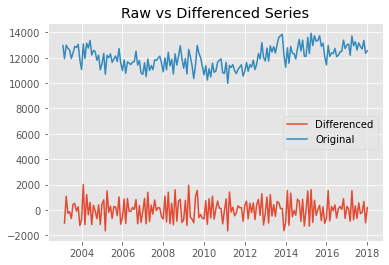

In [51]:
# This pandas method calculates diff of series with self, shifted by 1 (default number)
diff = series_sample(data, 'M').diff()

# Plot differenced series
plt.plot(diff, label="Differenced")
plt.plot(series_sample(data, 'M'), label="Original")
plt.title('Raw vs Differenced Series')
plt.legend()

plt.savefig('../data/images/differenced.png', dpi=250)

In [53]:
# Now check for stationarity with DF test
sm.tsa.adfuller(diff.dropna())

(-4.820614017978506,
 4.96570212391087e-05,
 11,
 167,
 {'1%': -3.470126426071447,
  '5%': -2.8790075987120027,
  '10%': -2.5760826967621644},
 2518.133031669052)

2
